C:\Users\Rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:05:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3897
           1       0.95      0.95      0.95     24021
           2       0.92      0.92      0.92     16082

    accuracy                           0.94     44000
   macro avg       0.96      0.96      0.96     44000
weighted avg       0.94      0.94      0.94     44000



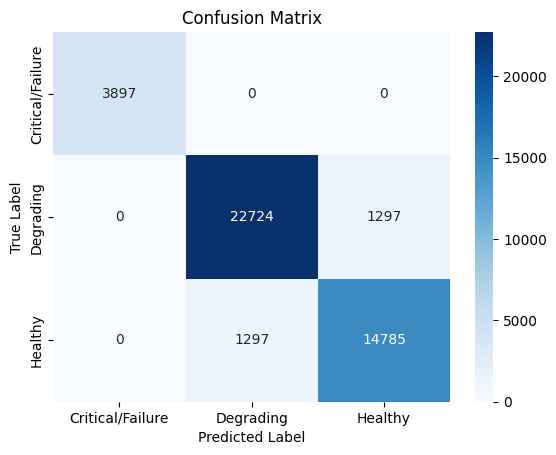

Subset 1 - R² Score: 0.9830, MSE: 7.7240, MAE: 1.7786
Subset 2 - R² Score: 0.9831, MSE: 7.6010, MAE: 1.7708
Subset 3 - R² Score: 0.9826, MSE: 7.9016, MAE: 1.7877
Subset 4 - R² Score: 0.9829, MSE: 7.6651, MAE: 1.7641
Subset 5 - R² Score: 0.9828, MSE: 7.8101, MAE: 1.7740
Overall Regression Model R² Score: 0.9444
Overall Regression Model MSE: 24.9070
Overall Regression Model MAE: 3.5987
The model performs very well, accurately predicting radiator performance.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

file_path = "radiator_final_faults.csv"
df = pd.read_csv(file_path)

df.columns = df.columns.str.replace(r"[\[\]<>]", "", regex=True).str.replace(" ", "_")

df.rename(columns={
    "CoolantTemperature°C": "CoolantTemperature_C",
    "CoolantFlowRateL/min": "CoolantFlowRate_L_per_min",
    "AmbientTemperature°C": "AmbientTemperature_C",
    "RadiatorCloggingPercentage": "RadiatorClogging_Percentage",
    "FanSpeedRPM": "FanSpeed_RPM",
    "CorrosionLevelPercentage": "CorrosionLevel_Percentage",
    "HeatExchangerEfficiencyPercentage": "HeatExchangerEfficiency_Percentage",
    "OilTemperature°C": "OilTemperature_C",
    "EngineLoadPercentage": "EngineLoad_Percentage",
    "PressureInRadiatorPSI": "PressureInRadiator_PSI"
}, inplace=True)

def classify_health(performance):
    if performance >= 80:
        return 2  
    elif 50 <= performance < 80:
        return 1 
    else:
        return 0  

df["HealthStatus"] = df["RadiatorPerformance"].apply(classify_health)

X_class = df.drop(columns=["RadiatorPerformance", "HealthStatus"])
y_class = df["HealthStatus"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_c, y_train_c)

y_pred_class = xgb_model.predict(X_test_c)
print("Classification Report:")
print(classification_report(y_test_c, y_pred_class))

conf_matrix = confusion_matrix(y_test_c, y_pred_class)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Critical/Failure", "Degrading", "Healthy"], yticklabels=["Critical/Failure", "Degrading", "Healthy"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

X_train_c = X_train_c.copy()
X_test_c = X_test_c.copy()
X_train_c["PredictedHealthStatus"] = xgb_model.predict(X_train_c)
X_test_c["PredictedHealthStatus"] = y_pred_class

X_reg = X_train_c
y_reg = df.loc[X_train_c.index, "RadiatorPerformance"]

X_test_reg = X_test_c
y_test_reg = df.loc[X_test_c.index, "RadiatorPerformance"]

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_reg, y_reg)

num_subsets = 5
df_subsets = np.array_split(df, num_subsets)

for i, subset in enumerate(df_subsets):
    X_subset = subset.drop(columns=["RadiatorPerformance", "HealthStatus"])
    X_subset["PredictedHealthStatus"] = xgb_model.predict(X_subset)
    y_subset = subset["RadiatorPerformance"]
    y_pred_subset = rf_regressor.predict(X_subset)
    r2_subset = r2_score(y_subset, y_pred_subset)
    mse_subset = mean_squared_error(y_subset, y_pred_subset)
    mae_subset = mean_absolute_error(y_subset, y_pred_subset)
    print(f"Subset {i+1} - R² Score: {r2_subset:.4f}, MSE: {mse_subset:.4f}, MAE: {mae_subset:.4f}")

y_pred_reg = rf_regressor.predict(X_test_reg)

r2 = r2_score(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"Overall Regression Model R² Score: {r2:.4f}")
print(f"Overall Regression Model MSE: {mse:.4f}")
print(f"Overall Regression Model MAE: {mae:.4f}")

if r2 > 0.8:
    print("The model performs very well, accurately predicting radiator performance.")
elif r2 > 0.6:
    print("The model performs decently but could be improved with additional features or tuning.")
else:
    print("The model has poor predictive power; more feature engineering and tuning may be needed.")